In [1]:
#Import the libraries
import os,random
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa as lib
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import wavfile as wav
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import accuracy_score

from tensorflow.keras.layers import Dense,Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
import IPython.display as ipd
%matplotlib inline

In [2]:
#Access the audio image filepath
train_audio_path = '../Dataset audio samples/classification dataset/'
test_audio_path = '../Dataset audio samples/classification test samples/'
labels = os.listdir(train_audio_path)
print(labels)

['left', 'one', 'right', 'stop', 'three', 'two']


In [3]:
#Audio signal EDA and visualization
test_sample, test_rate = lib.load(train_audio_path+'right/0ea0e2f4_nohash_0.wav', sr=8000)

print(test_sample.shape)
print(test_rate)
print(len(test_sample))
print(len(test_sample)/test_rate)

(8000,)
8000
8000
1.0


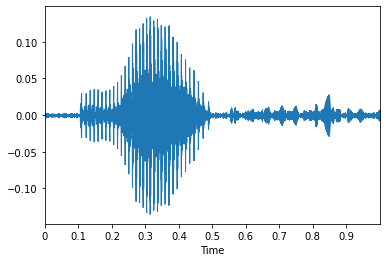

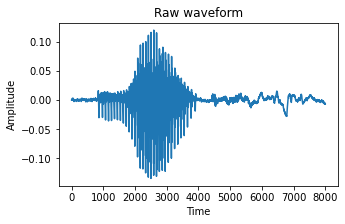

In [4]:
#Plotting the time-series amplitude-time waveform
librosa.display.waveplot(test_sample, test_rate)

#Plotting using matplotlib
plt.figure(figsize=(5,3))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Raw waveform')
plt.plot(test_sample)

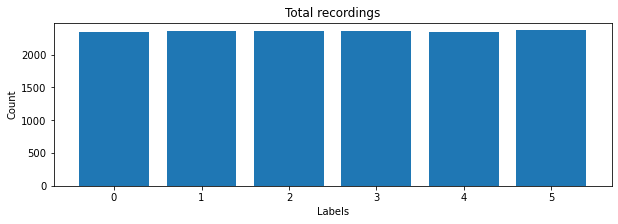

In [5]:
#No. of recordings in each label
sample_count=[]

for label in labels:
    sample_count.append(len([f for f in os.listdir(train_audio_path+label) if f.endswith('.wav')]))

#Plotting using matplotlib
plt.figure(figsize=(10,3))
index = np.arange(len(labels))
plt.bar(index, sample_count)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Total recordings')
plt.show(sample_count)

C:\Users\Mehak\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Mehak\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


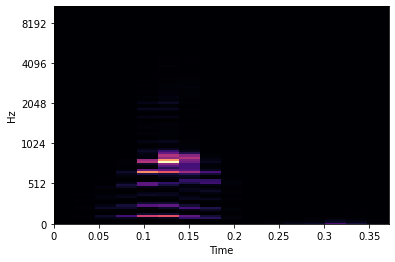

In [6]:
#Display spectogram
ipd.Audio(train_audio_path+'right/0ea0e2f4_nohash_0.wav')
spec = lib.feature.melspectrogram(test_sample,test_rate)
lib.display.specshow(spec, y_axis='mel', x_axis='time')

Scipy: sample, rate, bit-depth(min, max):  [  -9   -4   -8 ... -209 -197 -183] 16000 -4410 3930
Librosa: sample, rate, bit-depth(min, max):  [-0.00026596 -0.00018007 -0.000125   ... -0.00602599 -0.00643429
 -0.00410269] 22050 -0.13435018 0.12273543


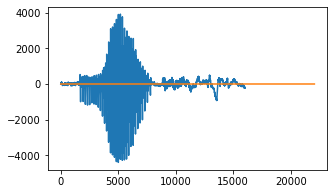

In [7]:
#Audio signal preprocessing
# 1. Resampling
# 2. Signal duration filtering (<1s)
# 3. Bit rate depth normalization
# 4. Stereo to mono channel
#
# Librosa libarary handles resampling (22.5kHz, sterso to mono channel, bit-depth normalization)
audio_file = train_audio_path+'right/0ea0e2f4_nohash_0.wav'
scipy_rate, scipy_audio= wav.read(audio_file)
lib_audio, lib_rate = lib.load(audio_file)


print('Scipy: sample, rate, bit-depth(min, max): ', scipy_audio, scipy_rate, np.min(scipy_audio), np.max(scipy_audio))
print('Librosa: sample, rate, bit-depth(min, max): ', lib_audio, lib_rate, np.min(lib_audio), np.max(lib_audio))

plt.figure(figsize=(5,3))
plt.plot(scipy_audio)
plt.plot(lib_audio)

In [8]:
#Preprocessing below:
#Resampling at 8000kHz
#Filtering out audio <1s in length
#Creating arrays of audio and its labels and create a dataframe from them

x_audio_array=[]
y_label_array=[]
sample_rate = 8000
count = 0
count1 = 0

for label in labels:
    audios = [f for f in os.listdir(train_audio_path+label) if f.endswith('.wav')]
    for aud in audios:
        count+=1
        #Resampling
        sam,rate = lib.load(train_audio_path+label+'/'+aud, sr=sample_rate)
        if len(sam)/rate == 1:
            count1+=1
            #Feature extraction using MFCC
            mfcc = lib.feature.mfcc(sam, sr = sample_rate, n_mfcc=40)
            x_audio_array.append(np.mean(mfcc.T, axis=0))
            y_label_array.append(label)

In [16]:
#Encoding categorical data(labels)
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y_label_array)
print(y_encoded.shape)
x_audios = np.array(x_audio_array).reshape(-1,40,1)
print(x_audios.shape)

(12837, 6)
(12837, 40, 1)


In [17]:
#Split datasets into training and test data
x_train, x_test, y_train, y_test = train_test_split(x_audios, y_encoded, test_size=0.3, random_state=42)
print(x_train.shape)

(8985, 40, 1)


In [18]:
#Create 1D conv1d CNN model

cnn1d = Sequential()

#1st 1D conv layer and maxpooling layer
cnn1d.add(Conv1D(filters=16, kernel_size = 2, activation='relu', input_shape=(40,1)))
cnn1d.add(MaxPooling1D(pool_size=2, strides=1))

#2nd 1D conv layer and maxpooling layer
cnn1d.add(Conv1D(filters=32, kernel_size = 2, activation='relu'))
cnn1d.add(MaxPooling1D(pool_size=2, strides=1))

#3rd 1D conv layer and maxpooling layer
cnn1d.add(Conv1D(filters=64, kernel_size = 2, activation='relu'))
cnn1d.add(MaxPooling1D(pool_size=2, strides=1))

#4th 1D conv layer and maxpooling layer
cnn1d.add(Conv1D(filters=64, kernel_size = 2, activation='relu'))
cnn1d.add(MaxPooling1D(pool_size=2, strides=1))

#Flattening
cnn1d.add(Flatten())

#Fully connected layer
cnn1d.add(Dense(units=64, activation='relu'))
cnn1d.add(Dropout(0.3))

#Output layer
cnn1d.add(Dense(units=6, activation='softmax'))

cnn1d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 39, 16)            48        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 38, 16)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 37, 32)            1056      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 36, 32)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 35, 64)            4160      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 34, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 33, 64)           

In [19]:
#Compile CNN
cnn1d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Fit the model(train)
cnn1d.fit(x_train, y_train, batch_size=32, epochs=150)

Epoch 1/150
281/281 [==============================] - 2s 9ms/step - loss: 1.5956 - accuracy: 0.3221
Epoch 2/150
281/281 [==============================] - 3s 9ms/step - loss: 1.3594 - accuracy: 0.4460
Epoch 3/150
281/281 [==============================] - 3s 9ms/step - loss: 1.2872 - accuracy: 0.4851: 0s - loss: 1.2878 - accuracy: 0.
Epoch 4/150
281/281 [==============================] - 3s 10ms/step - loss: 1.2442 - accuracy: 0.5058
Epoch 5/150
281/281 [==============================] - 3s 10ms/step - loss: 1.2035 - accuracy: 0.5228
Epoch 6/150
281/281 [==============================] - 3s 10ms/step - loss: 1.1693 - accuracy: 0.5427
Epoch 7/150
281/281 [==============================] - 3s 9ms/step - loss: 1.1392 - accuracy: 0.5526
Epoch 8/150
281/281 [==============================] - 3s 9ms/step - loss: 1.0958 - accuracy: 0.5701
Epoch 9/150
281/281 [==============================] - 2s 9ms/step - loss: 1.0783 - accuracy: 0.5736
Epoch 10/150
281/281 [==============================] 

281/281 [==============================] - 2s 9ms/step - loss: 0.2560 - accuracy: 0.8958: 0s - loss: 0.2555 - accuracy: 0.89
Epoch 81/150
281/281 [==============================] - 3s 9ms/step - loss: 0.2521 - accuracy: 0.9023
Epoch 82/150
281/281 [==============================] - 2s 9ms/step - loss: 0.2547 - accuracy: 0.8989
Epoch 83/150
281/281 [==============================] - 3s 9ms/step - loss: 0.2603 - accuracy: 0.9015
Epoch 84/150
281/281 [==============================] - 2s 9ms/step - loss: 0.2627 - accuracy: 0.8972
Epoch 85/150
281/281 [==============================] - 2s 9ms/step - loss: 0.2495 - accuracy: 0.8977
Epoch 86/150
281/281 [==============================] - 2s 9ms/step - loss: 0.2440 - accuracy: 0.9026
Epoch 87/150
281/281 [==============================] - 2s 9ms/step - loss: 0.2511 - accuracy: 0.8993
Epoch 88/150
281/281 [==============================] - 3s 9ms/step - loss: 0.2453 - accuracy: 0.9024
Epoch 89/150
281/281 [==============================] - 2s 

In [20]:
#Evaluating the model accuracy
print('Training data accuracy: ', cnn1d.evaluate(x_train, y_train, verbose=0))
print('Testing data accuracy: ', cnn1d.evaluate(x_test, y_test, verbose=0))

Training data accuracy:  [0.04240643233060837, 0.9914301633834839]
Testing data accuracy:  [3.3218836784362793, 0.5747663378715515]


In [21]:
#Predict using cnn1d model
res=cnn1d.predict(x_test)
print(lb.inverse_transform((res[0].reshape(1,-1)))[0])
print('Accuracy score: ', accuracy_score(lb.inverse_transform(y_test),lb.inverse_transform(res)))

stop
Accuracy score:  0.5747663551401869


In [22]:
import sounddevice as sd
from scipy.io.wavfile import write

def record_audio():
    rate = 8000  # Sample rate
    seconds = 1  # Duration of recording

    my_audio = sd.rec(int(seconds * rate), samplerate=rate, channels=1)
    sd.wait()  # Wait until recording is finished
    write(test_audio_path + 'test.wav', rate, my_audio)  # Save as WAV file 
    return 'test.wav'
    
def predict_audio(filename):
    filepath = test_audio_path + filename
    audio, sam = lib.load(filepath, sr=8000)
    mfcc = lib.feature.mfcc(audio, sr = sample_rate, n_mfcc=40)
    mfcc_scaled = np.mean(mfcc.T, axis=0)
    pad_width = 40 - mfcc_scaled.shape[0]
    mfcc_scaled = np.pad(mfcc_scaled, pad_width=(0,pad_width))
        
    audio_predicted=cnn1d.predict(mfcc_scaled.reshape(1,mfcc_scaled.shape[0],1))
    audio_class = lb.inverse_transform(audio_predicted) 
    print('Your audio (' + filename + ') belongs to the label: ', audio_class[0].upper())

In [23]:
#Classify a random audio file from the unlabelled test folder
file = random.choice([f for f in os.listdir(test_audio_path)])
predict_audio(file)
ipd.Audio(test_audio_path+file, autoplay=True)

Your audio (one4.wav) belongs to the label:  ONE


In [ ]:
#Classify a live spoken audio through microphone
predict_audio(record_audio())
ipd.Audio(test_audio_path+'test.wav', autoplay=True)